In [46]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

In [56]:
water = pd.read_csv('drinking_water_potability.csv')
water.head()
water = water.dropna()
water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.68774,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.71654,7.513408,393.663395,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.09176,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


In [57]:
np.random.seed(2)
# 80% to be training
train = water.sample(round(water.shape[0]*.8))
# drop the train data from the test df
test = water.drop(train.index)

In [58]:
def confusion_matrix_test(data,actual_values,model,cutoff=0.48):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    return cm

def accuracytest(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    #sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    #plt.ylabel("Actual Values")
    #plt.xlabel("Predicted Values")
    #print("Classification accuracy = {:.1%}".format(accuracy))
    return accuracy

Optimization terminated successfully.
         Current function value: 0.671184
         Iterations 4
Classification accuracy = 60.4%


array([1191.,    9.])

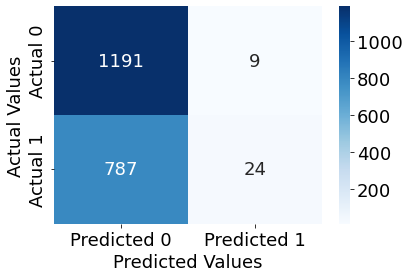

In [50]:
logit_model = sm.logit(formula = 'Potability~Hardness*Solids+Chloramines*Sulfate+\
                Organic_carbon*Sulfate+Conductivity*Hardness+Chloramines*Organic_carbon', data = water).fit() #Developing logistic regression model
logit_model.summary()
accuracy,cm = confusion_matrix_test(water,water.Potability,logit_model,.5)
accuracy

In [59]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Accuracy'].argmax()]
    return best_model

In [60]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    accuracy = models_best.apply(lambda row: accuracytest(test,test.Potability,row[1],cutoff=0.5), axis=1)
    plt.plot(models_best["Accuracy"])
    plt.plot(1+accuracy.argmax(), accuracy.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Accuracy')

In [61]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('Potability~' + '+'.join(predictor_subset),data = train).fit()
    accuracy = accuracytest(test,test.Potability,model,cutoff=0.5)
    return {"model":model, "Accuracy":accuracy}

In [9]:
train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
773,6.848330,195.451482,15908.64209,6.241349,319.264722,404.204859,18.937338,75.392795,3.732202,1
1200,8.016279,211.029304,14034.48580,9.797000,389.338796,491.079082,14.512991,35.565966,4.308223,1
1086,7.845880,193.785000,13769.86024,9.007161,343.620823,510.305603,13.767802,99.175595,3.667154,1
3057,7.985406,200.134697,17583.08033,6.771729,296.569823,377.584203,10.289288,66.890747,4.752452,0
2965,9.459931,222.894659,14450.17575,6.790914,293.746321,433.145005,9.069161,67.906813,3.322890,0


In [62]:
#RUN ONCE otherwise X will expand like crazy
from sklearn.metrics import r2_score
import itertools
X = train.loc[:, train.columns!='Potability']
train2 = train.copy()
test2 = test.copy()
#Creating a dataframe with all the predictors
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train.loc[:, train.columns!='Potability']
#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]

/var/folders/rx/6t25_k4d15j9qj7gtlvqdlqc0000gr/T/ipykernel_36112/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/rx/6t25_k4d15j9qj7gtlvqdlqc0000gr/T/ipykernel_36112/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/rx/6t25_k4d15j9qj7gtlvqdlqc0000gr/T/ipykernel_36112/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a c

/var/folders/rx/6t25_k4d15j9qj7gtlvqdlqc0000gr/T/ipykernel_36112/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/rx/6t25_k4d15j9qj7gtlvqdlqc0000gr/T/ipykernel_36112/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/rx/6t25_k4d15j9qj7gtlvqdlqc0000gr/T/ipykernel_36112/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a c

In [11]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
'''models_best = pd.DataFrame(columns=["Accuracy", "model"])

for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)
models_best'''

KeyboardInterrupt: 

Optimization terminated successfully.
         Current function value: 0.676568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676697
  

Optimization terminated successfully.
         Current function value: 0.673929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674145
  

Optimization terminated successfully.
         Current function value: 0.665825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664157
  

Optimization terminated successfully.
         Current function value: 0.663009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664684
  

Optimization terminated successfully.
         Current function value: 0.663993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.664143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664296
  

Optimization terminated successfully.
         Current function value: 0.660067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656717
  

Optimization terminated successfully.
         Current function value: 0.651082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657731
  

Optimization terminated successfully.
         Current function value: 0.635423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629461
  

Optimization terminated successfully.
         Current function value: 0.623481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635010
  

Optimization terminated successfully.
         Current function value: 0.633477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634931
  

Optimization terminated successfully.
         Current function value: 0.622534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632554
  

Optimization terminated successfully.
         Current function value: 0.620917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621097
  

Optimization terminated successfully.
         Current function value: 0.614295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.602617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605212
  

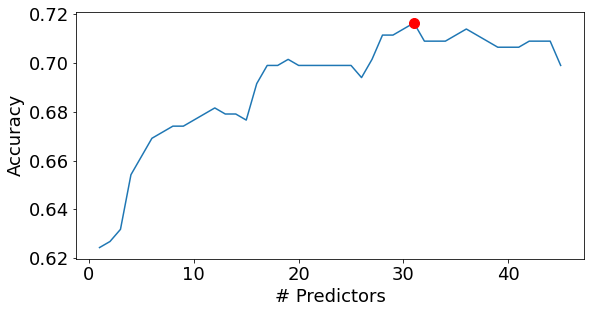

In [63]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Accuracy'].argmax()]

    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["Accuracy", "model"])

    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])
    return models_best

models_best = forward_selection()
best_sub_plots()


In [64]:
models_best.Accuracy.sort_values(ascending=False)

31    0.716418
30     0.71393
36     0.71393
35    0.711443
28    0.711443
29    0.711443
37    0.711443
38    0.708955
34    0.708955
33    0.708955
32    0.708955
42    0.708955
43    0.708955
44    0.708955
39    0.706468
40    0.706468
41    0.706468
27    0.701493
19    0.701493
23    0.699005
24    0.699005
25    0.699005
45    0.699005
22    0.699005
21    0.699005
20    0.699005
18    0.699005
17    0.699005
26     0.69403
16    0.691542
12    0.681592
11    0.679104
13    0.679104
14    0.679104
15    0.676617
10    0.676617
9     0.674129
8     0.674129
7     0.671642
6     0.669154
5     0.661692
4     0.654229
3     0.631841
2     0.626866
1     0.624378
Name: Accuracy, dtype: object

In [65]:
models_best.loc[31,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Potability   No. Observations:                 1609
Model:                          Logit   Df Residuals:                     1577
Method:                           MLE   Df Model:                           31
Date:                Sat, 04 Mar 2023   Pseudo R-squ.:                 0.08212
Time:                        16:55:08   Log-Likelihood:                -999.40
converged:                       True   LL-Null:                       -1088.8
Covariance Type:            nonrobust   LLR p-value:                 1.035e-22
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        9.9886      4.723      2.115      0.034       0.733      19.245
Solids_Conductivity            5.27e-08   8.04e-08      0.655      0.512   -1.05e-07     2.1e-07
ph_Chloramines                   0.1589      0.025      6.379      0.000       0.110       0.208
Chloramines                     -1.2603      0.502     -2.512      0.012      -2.244      -0.277
ph_Sulfate                      -0.0056      0.001     -6.171      0.000      -0.007      -0.004
ph_Organic_carbon                0.0069      0.011      0.657      0.511      -0.014       0.028
Sulfate_Trihalomethanes       5.142e-05   6.35e-05      0.809      0.418   -7.31e-05       0.000
ph_Turbidity                     0.0281      0.049      0.577      0.564      -0.067       0.123
Hardness_Turbidity               0.0007      0.002      0.331      0.740      -0.004       0.005
Hardness_Organic_carbon         -0.0002      0.000     -0.415      0.678      -0.001       0.001
Hardness_Chloramines            -0.0024      0.001     -2.252      0.024      -0.005      -0.000
ph_Solids                     1.987e-05   4.24e-06      4.690      0.000    1.16e-05    2.82e-05
Conductivity_Trihalomethanes  1.331e-05   3.81e-05      0.350      0.727   -6.13e-05    8.79e-05
Hardness                        -0.0475      0.021     -2.315      0.021      -0.088      -0.007
Chloramines_Organic_carbon      -0.0044      0.009     -0.464      0.642      -0.023       0.014
Hardness_Solids              -3.513e-07   2.07e-07     -1.698      0.089   -7.57e-07    5.41e-08
Chloramines_Sulfate              0.0019      0.001      2.567      0.010       0.000       0.003
Chloramines_Trihalomethanes     -0.0012      0.002     -0.553      0.580      -0.005       0.003
Conductivity                    -0.0111      0.007     -1.561      0.118      -0.025       0.003
Solids_Trihalomethanes        2.636e-07   4.06e-07      0.649      0.517   -5.33e-07    1.06e-06
Solids                           0.0001   9.85e-05      1.036      0.300    -9.1e-05       0.000
Turbidity                       -0.4051      0.749     -0.541      0.589      -1.874       1.064
Solids_Turbidity              1.579e-06   8.58e-06      0.184      0.854   -1.52e-05    1.84e-05
Solids_Organic_carbon         4.155e-07   1.84e-06      0.225      0.822    -3.2e-06    4.03e-06
Chloramines_Conductivity         0.0003      0.000      0.601      0.548      -0.001       0.001
Chloramines_Turbidity            0.0045      0.046      0.097      0.923      -0.086       0.095
Solids_Sulfate               -6.454e-07   1.59e-07     -4.068      0.000   -9.56e-07   -3.34e-07
Hardness_Sulfate                 0.0002   3.48e-05      5.066      0.000       0.000       0.000
Hardness_Conductivity         3.279e-05   2.06e-05      1.594      0.111   -7.54e-06    7.31e-05
ph                               0.2987      0.479      0.624      0.533      -0.640       1.237
ph_Trihalomethanes              -0.0028 

Classification accuracy = 71.6%


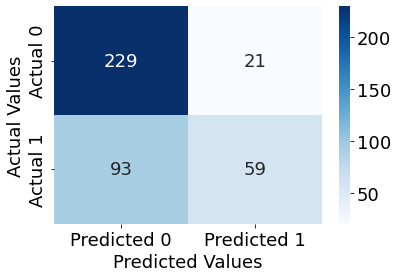

In [67]:
cm = confusion_matrix_test(test,test.Potability,models_best.loc[31,'model'],cutoff=0.5)

In [70]:
recall = cm[1,1]/(cm[1,1]+cm[1,0])
fpr = cm[0,1]/(cm[0,1]+cm[1,0])
print(recall,fpr)

0.3881578947368421 0.18421052631578946


Optimization terminated successfully.
         Current function value: 0.674403
         Iterations 4
Classification accuracy = 62.4%


array([[249.,   1.],
       [150.,   2.]])

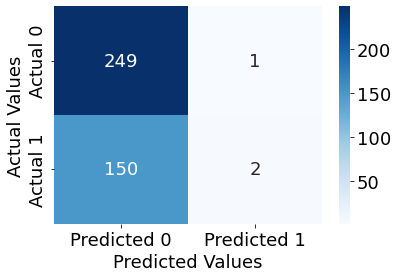

In [24]:
#model with all 
model_all = sm.logit("Potability~" + "+".join(X_backup.columns), data = train2).fit()
confusion_matrix_test(test, test.Potability, model_all)

Optimization terminated successfully.
         Current function value: 0.671369
         Iterations 5
Classification accuracy = 63.2%
Optimization terminated successfully.
         Current function value: 0.669043
         Iterations 5
Classification accuracy = 60.0%
Optimization terminated successfully.
         Current function value: 0.674215
         Iterations 4
Classification accuracy = 61.9%
Optimization terminated successfully.
         Current function value: 0.669344
         Iterations 4
Classification accuracy = 62.7%
Optimization terminated successfully.
         Current function value: 0.662274
         Iterations 5
Classification accuracy = 64.9%
Optimization terminated successfully.
         Current function value: 0.673812
         Iterations 4
Classification accuracy = 61.7%
Optimization terminated successfully.
         Current function value: 0.674089
         Iterations 4
Classification accuracy = 62.2%
Optimization terminated successfully.
         Current functio

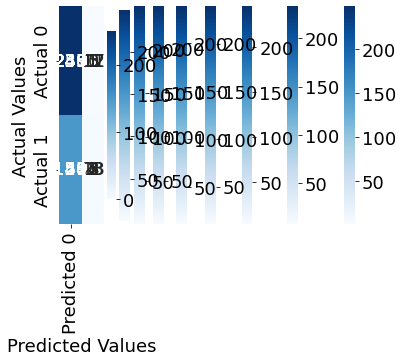

In [27]:
for i in model_all.params.index[1:]:
    model = sm.logit("Potability~" + "+".join(X_backup.columns) + "+I(" + i + "**2)", data = train2).fit()
    confusion_matrix_test(test, test.Potability, model)

In [41]:
best_in_model = models_best.loc[33,'model']
best_in_model.params.index[1:]

Index(['Solids_Conductivity', 'ph_Chloramines', 'Chloramines', 'ph_Sulfate',
       'Chloramines_Sulfate', 'Organic_carbon_Trihalomethanes', 'ph_Hardness',
       'Hardness', 'ph_Organic_carbon', 'Solids_Chloramines', 'Solids_Sulfate',
       'Hardness_Trihalomethanes', 'Trihalomethanes', 'Turbidity',
       'Hardness_Turbidity', 'Sulfate_Conductivity', 'ph_Solids',
       'Solids_Trihalomethanes', 'Chloramines_Trihalomethanes',
       'Hardness_Solids', 'Organic_carbon', 'Solids_Turbidity',
       'ph_Trihalomethanes', 'ph_Turbidity', 'Organic_carbon_Turbidity',
       'Solids_Organic_carbon', 'ph', 'Solids', 'Sulfate_Organic_carbon',
       'Chloramines_Conductivity', 'Hardness_Conductivity',
       'Conductivity_Organic_carbon', 'Conductivity_Trihalomethanes'],
      dtype='object')

Optimization terminated successfully.
         Current function value: 0.617715
         Iterations 6
Classification accuracy = 67.2%
Optimization terminated successfully.
         Current function value: 0.619973
         Iterations 6
Classification accuracy = 67.7%
Optimization terminated successfully.
         Current function value: 0.623241
         Iterations 6
Classification accuracy = 68.7%
Optimization terminated successfully.
         Current function value: 0.618928
         Iterations 6
Classification accuracy = 70.1%
Optimization terminated successfully.
         Current function value: 0.596710
         Iterations 6
Classification accuracy = 71.4%
Optimization terminated successfully.
         Current function value: 0.617484
         Iterations 6
Classification accuracy = 68.4%
Optimization terminated successfully.
         Current function value: 0.622295
         Iterations 6
Classification accuracy = 69.7%
Optimization terminated successfully.
         Current functio

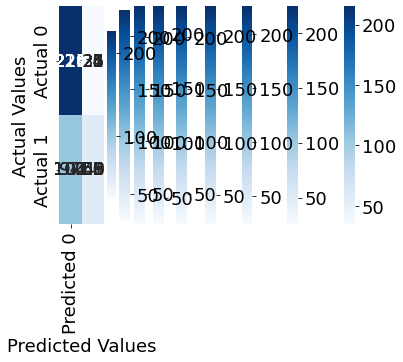

In [49]:
for i in model_all.params.index[1:]:
    model = sm.logit("Potability~" + "+".join(best_in_model.params.index[1:]) + "+I(" + i + "**2)+I(" + i + "**3)", data = train).fit()
    confusion_matrix_test(test, test.Potability, model)

Optimization terminated successfully.
         Current function value: 0.596710
         Iterations 6
Classification accuracy = 71.9%


array([[222.,  28.],
       [ 85.,  67.]])

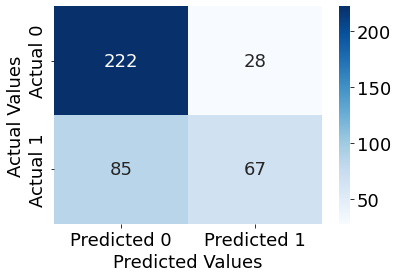

In [63]:
model_best = sm.logit("Potability~" + "+".join(best_in_model.params.index[1:]) + "+I(Sulfate**2)+I(Sulfate**3)", data = train).fit()
confusion_matrix_test(test, test.Potability, model_best)